# Table of Contents
 <p><div class="lev1"><a href="#Preparation"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></div><div class="lev2"><a href="#Import-all-required-libraries"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import all required libraries</a></div><div class="lev2"><a href="#Create-functions-to-calculate-scalings"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create functions to calculate scalings</a></div><div class="lev2"><a href="#Start-a-local-computational-cluster,-use-10-cores"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Start a local computational cluster, use 10 cores</a></div><div class="lev2"><a href="#Load-chromosomes-sizes-for-male-and-female-haplotype-genomes"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load chromosomes sizes for male and female haplotype genomes</a></div><div class="lev2"><a href="#Load-pairs-into-a-dictionary"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Load pairs into a dictionary</a></div><div class="lev1"><a href="#Calculate-scalings---an-expensive-operation!"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate scalings - an <em>expensive</em> operation!</a></div><div class="lev1"><a href="#Visualizations"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizations</a></div><div class="lev2"><a href="#Cis-scalings-for-all-samples,-normalized-at-a-given-distance"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cis scalings for all samples, normalized at a given distance</a></div><div class="lev2"><a href="#Cis-scalings-for-all-chromosomes-in-one-sample,-normalized-at-a-given-distance"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cis scalings for all chromosomes in one sample, normalized at a given distance</a></div><div class="lev2"><a href="#Trans-scalings,-normalized-by-cis-contact-frequencies-at-a-given-distance"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Trans scalings, normalized by cis contact frequencies at a given distance</a></div>

# Preparation

## Import all required libraries

In [1]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn.apionly as sns
mpl.style.use('seaborn-poster')
pal = sns.palettes.get_color_cycle()

import numpy as np
import pandas as pd
import bioframe
import bioframe.dask
import dask
import dask.array as da

import distributed

## Create functions to calculate scalings

In [2]:
def geomprog(factor, start=1):
    yield start
    while True:
        start *= factor
        yield start


def _geomrange(start, end, factor, endpoint):
    prev = np.nan
    for i in geomprog(factor, start):
        x = int(round(i))
        
        if x > end:
            break

        if x == prev:
            continue
        
        prev = x
        yield x

    if endpoint and prev != end:
        yield end


def geomrange(start, end, factor, endpoint=False):
    return np.fromiter(_geomrange(start, end, factor, endpoint), dtype=int)


def geomspace(start, end, num=50, endpoint=True):
    factor = 1 + ((np.log10(end) - np.log10(start)) / num)
    return geomrange(start, end, factor, endpoint=endpoint)


def _contact_areas(distbins, scaffold_length):
    distbins = distbins.astype(float)
    scaffold_length = float(scaffold_length)
    outer_areas = np.maximum(scaffold_length - distbins[:-1], 0) ** 2
    inner_areas = np.maximum(scaffold_length - distbins[1: ], 0) ** 2
    return 0.5 * (outer_areas - inner_areas)
    

def contact_areas(distbins, region1, region2):
    if region1 == region2:
        start, end = region1
        areas = _contact_areas(distbins, end - start)
    else:
        start1, end1 = region1
        start2, end2 = region2
        if start2 <= start1:
            start1, start2 = start2, start1
            end1, end2 = end2, end1
        areas = (
            _contact_areas(distbins, end2 - start1) -
            _contact_areas(distbins, start2 - start1) -
            _contact_areas(distbins, end2 - end1)
        )
        if end1 < start2:
            areas += _contact_areas(distbins, start2 - end1)
    
    return areas


def compute_scaling(df, 
                    region1, 
                    region2=None, 
                    dmin=int(1e1), 
                    dmax=int(1e8), 
                    n_bins=50):

    if region2 is None:
        region2 = region1
    
    distbins = geomspace(dmin, dmax, n_bins)
    areas = contact_areas(distbins, region1, region2)

    df = df[ 
        (df['pos1'] >= region1[0]) & 
        (df['pos1'] < region1[1]) & 
        (df['pos2'] >= region2[0]) & 
        (df['pos2'] < region2[1])
    ]
    dists = (df['pos2'] - df['pos1']).values

    if isinstance(dists, da.Array):
        dists = da.absolute(dists)
        obs, _ = da.histogram(
            dists[(dists >= dmin) & (dists < dmax)],
            bins=distbins)
    else:
        dists = np.absolute(dists)
        obs, _ = np.histogram(
            dists[(dists >= dmin) & (dists < dmax)],
            bins=distbins)

    return distbins, obs, areas


## Start a local computational cluster, use 10 cores

In [3]:
cluster = distributed.LocalCluster(n_workers=10)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38265,Cluster Workers: 10 Cores: 40 Memory: 270.36 GB


## Load chromosomes sizes for male and female haplotype genomes

In [4]:
chromsizesMale = pd.read_table(
    '/net/levsha/share/lab/genomes/phased/dm3-057-439-JJ-snps-hybrid/dm3_057_439-JJ-snps-hybrid.reduced.chromsizes',
    header=None)
chromsizesMale = dict(zip(chromsizesMale.iloc[:,0],chromsizesMale.iloc[:,1]))

chromsizesFemale = pd.read_table(
    '/net/levsha/share/lab/genomes/phased/dm3-057-439-JJ-snps-embryo/dm3_057_439-JJ-snps-embryo.reduced.chromsizes',
    header=None)
chromsizesFemale = dict(zip(chromsizesFemale.iloc[:,0],chromsizesFemale.iloc[:,1]))

## Load pairs into a dictionary

In [5]:
pairs = {}

pairs['WT'] = bioframe.dask.daskify_pairix(
    '/net/levsha/share/lab/DrosophilaWulab/pairsam/20170729-HiC-dm3-057-439-JJ-snps-hybrid/JJ17_18.dedup.pairs.gz',
    chromsizesMale, 
    columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type', 'mapq1', 'mapq2'])

pairs['embryos'] = bioframe.dask.daskify_pairix(
    '/net/levsha/share/lab/DrosophilaWulab/pairsam/20171016-hic-dm3-057-439-jj-snps-embryos/JJ25_26_4lanes.dedup.pairs.gz',
    chromsizesFemale, 
    columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type', 'mapq1', 'mapq2'])

# pairs['embryos_0_2hr'] = bioframe.dask.daskify_pairix(
#     '/net/levsha/share/lab/DrosophilaWulab/pairsam/20171016-hic-dm3-057-439-jj-snps-0-2h-embryos/JEb5_6.dedup.pairs.gz',
#     chromsizesFemale, 
#     columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type', 'mapq1', 'mapq2'])

# pairs['slmb'] = bioframe.dask.daskify_pairix(
#     '/net/levsha/share/lab/DrosophilaWulab/pairsam/20170927-hic-dm3-057-439-jj-snps-hybrid/JJ29_30.dedup.pairs.gz',
#     chromsizesMale, 
#     columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type', 'mapq1', 'mapq2'])

# pairs['mock'] = bioframe.dask.daskify_pairix(
#     '/net/levsha/share/lab/DrosophilaWulab/pairsam/20170927-hic-dm3-057-439-jj-snps-hybrid/JJ27_28.dedup.pairs.gz',
#     chromsizesMale, 
#     columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type', 'mapq1', 'mapq2'])

# pairs['top2'] = bioframe.dask.daskify_pairix(
#     '/net/levsha/share/lab/DrosophilaWulab/pairsam/20171016-hic-dm3-057-439-jj-snps-hybrid/JJ31_32.dedup.pairs.gz',
#     chromsizesMale, 
#     columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type', 'mapq1', 'mapq2'])

# Calculate scalings - an *expensive* operation!

In [6]:
scalings_cis = {}
for sample in pairs:
    print(sample, '...')
    orientations = [
        ('+', '-'),
        ('-', '+'),
        ('+', '+'),
        ('-', '-')
    ]
    
    chromsizes = (chromsizesFemale if 'embryos' in sample
                   else chromsizesMale)
    

    scalings_cis[sample] = {}
    for chrom in chromsizes:
        print(chrom)
        scalings_cis[sample][chrom] = {}
        chrom_cis_pairs = pairs[sample][chrom, chrom].compute()
        grouped = chrom_cis_pairs.groupby(('strand1','strand2'))
        
        for s1, s2 in orientations:
            group = grouped.get_group((s1, s2))
            scalings_cis[sample][chrom][s1+s2]  = compute_scaling(
                group, 
                [0, chromsizes[chrom]], 
                [0, chromsizes[chrom]])
        

WT ...
chr2L_057
chr2R_057
chr2L_439
chr2R_439
chr3L_057
chr3R_057
chr3L_439
chr3R_439
chrX_057
embryos ...
chr2L_057
chr2R_057
chr2L_439
chr2R_439
chr3L_057
chr3R_057
chr3L_439
chr3R_439
chrX_057
chrX_439


In [7]:
scalings_trans = {}
for sample in pairs:
    print(sample, '...')

    orientations = [('+', '-'), ('-', '+'), ('+', '+'), ('-', '-')]

    chromsizes = (chromsizesFemale if 'embryos' in sample
                   else chromsizesMale)

    scalings_trans[sample] = {}

    for chrom in chromsizes:

        if (chrom.endswith('439')
            or (sample!='embryos' and chrom.startswith('chrX'))):
            continue

        scalings_trans[sample][chrom] = {}

        chrom_trans_pairs = pairs[sample][
            chrom, chrom.replace('057', '439')].compute()
        grouped = chrom_trans_pairs.groupby(('strand1','strand2'))

        for (s1, s2) in orientations:
            group = grouped.get_group((s1, s2))
            scalings_trans[sample][chrom][s1 + s2] = \
                list(compute_scaling(group, [0, chromsizes[chrom]], [0,
                                chromsizes[chrom]]))
            scalings_trans[sample][chrom][s1 + s2][2]*= 2



WT ...
embryos ...


# Visualizations

## Cis scalings for all samples, normalized at a given distance

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


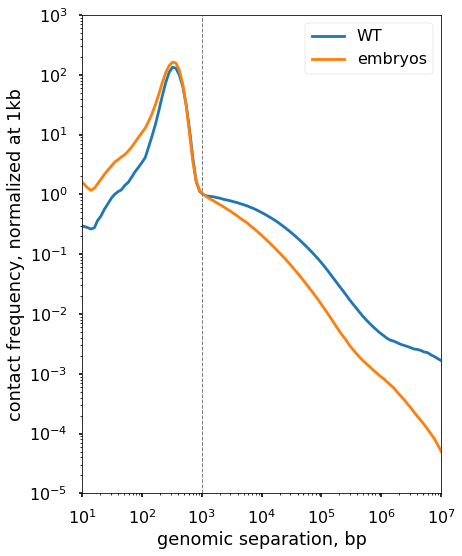

In [14]:
NORMALIZATION_DISTANCE = 1000

for sample in scalings_cis:
    bin_means = np.sqrt(scalings_cis[sample]['chr2L_057']['++'][0][:-1] 
                        * scalings_cis[sample]['chr2L_057']['++'][0][1:])
    
    ref_bin = np.searchsorted(bin_means, NORMALIZATION_DISTANCE)
    
    contact_counts = sum(scalings_cis[sample][chrom][orient][1] 
              for chrom in scalings_cis[sample]
               for orient in scalings_cis[sample][chrom]
             )
    
    areas = sum(scalings_cis[sample][chrom][orient][2] 
                for chrom in scalings_cis[sample]
                for orient in scalings_cis[sample][chrom]
              
               )
    contact_freqs = (contact_counts/areas)
    
    plt.loglog(
        bin_means, 
        contact_freqs/contact_freqs[ref_bin],
        label=sample
    )


plt.axvline(1000, c='gray', ls='--', lw=1)
plt.xlabel('genomic separation, bp')
plt.ylabel('contact frequency, normalized at {}kb'.format(NORMALIZATION_DISTANCE//1000))
plt.legend()
plt.ylim(1e-5,1e3)
plt.xlim(1e1,1e7)
plt.gca().set_aspect(1.0)
# plt.plot(
#     [1e3,1e7],
#     [1e1,10**(1-1.5*4)],
#     ls='--',
#     c='gray',
#     lw=0.5)
# for fmt in ['png', 'pdf']:
#     plt.savefig(figfolder+'/slmb_cis_scalings.{}'.format(fmt),
#                 bbox_inches='tight')

## Cis scalings for all chromosomes in one sample, normalized at a given distance

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


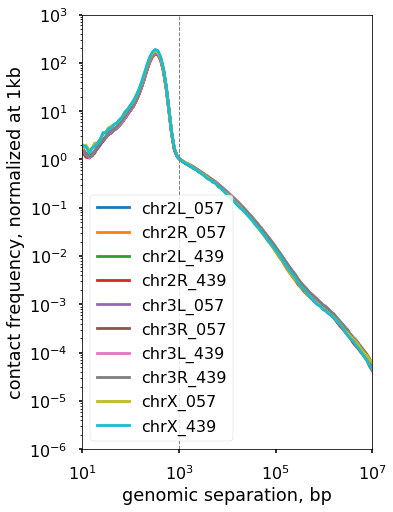

In [15]:
SAMPLE = 'embryos'

plt.figure(figsize=(8,8))

for chrom in scalings_cis[sample]:
    bin_means = np.sqrt(scalings_cis[sample]['chr2L_057']['++'][0][:-1] 
                        * scalings_cis[sample]['chr2L_057']['++'][0][1:])
    
    ref_bin = np.searchsorted(bin_means, NORMALIZATION_DISTANCE)
    
    contact_counts = sum(scalings_cis[sample][chrom][orient][1] 
               for orient in scalings_cis[sample][chrom]
             )
    
    areas = sum(scalings_cis[sample][chrom][orient][2] 
                for orient in scalings_cis[sample][chrom]
               )
    
    contact_freqs = (contact_counts/areas)

    plt.loglog(
        bin_means, 
        contact_freqs/contact_freqs[ref_bin],
        label=chrom
    )


plt.axvline(1000, c='gray', ls='--', lw=1)
plt.xlabel('genomic separation, bp')
plt.ylabel('contact frequency, normalized at 1kb')
plt.legend()
plt.ylim(1e-6,1e3)
plt.xlim(1e1,1e7)
plt.gca().set_aspect(1.0)
# for fmt in ['png', 'pdf']:
#     plt.savefig(figfolder+'/slmb_cis_scalings.{}'.format(fmt),
#                 bbox_inches='tight')

## Trans scalings, normalized by cis contact frequencies at a given distance

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


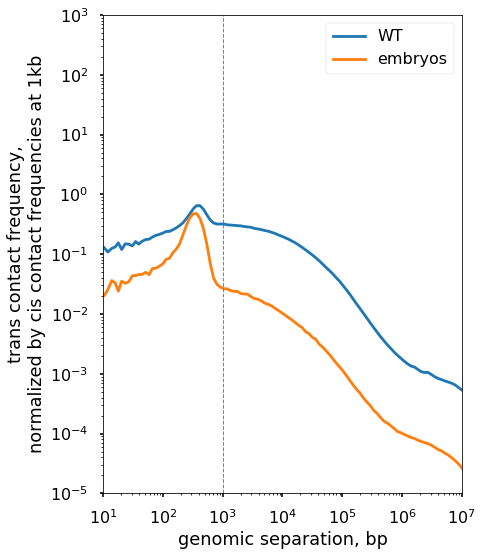

In [22]:
NORMALIZATION_DISTANCE = 1000

for sample in scalings_cis:
    bin_means = np.sqrt(scalings_cis[sample]['chr2L_057']['++'][0][:-1] 
                        * scalings_cis[sample]['chr2L_057']['++'][0][1:])
    
    ref_bin = np.searchsorted(bin_means, NORMALIZATION_DISTANCE)
    
    contact_counts_cis = sum(scalings_cis[sample][chrom][orient][1] 
               for chrom in scalings_cis[sample]
               for orient in scalings_cis[sample][chrom]
             )
    
    areas_cis = sum(scalings_cis[sample][chrom][orient][2] 
                for chrom in scalings_cis[sample]
                for orient in scalings_cis[sample][chrom]
              
               )
    contact_freqs_cis = (contact_counts_cis/areas_cis)


    contact_counts_trans = sum(scalings_trans[sample][chrom][orient][1] 
               for chrom in scalings_trans[sample]
               for orient in scalings_trans[sample][chrom]
             )
    
    areas_trans = sum(scalings_trans[sample][chrom][orient][2] 
                for chrom in scalings_trans[sample]
                for orient in scalings_trans[sample][chrom]
              
               )
    contact_freqs_trans = (contact_counts_trans/areas_trans)

    
    plt.loglog(
        bin_means, 
        contact_freqs_trans/(contact_freqs_cis[ref_bin]),
        label=sample
    )


plt.axvline(1000, c='gray', ls='--', lw=1)
plt.xlabel('genomic separation, bp')
plt.ylabel('trans contact frequency,\nnormalized by cis contact frequencies at {}kb'.format(NORMALIZATION_DISTANCE//1000))
plt.legend()
plt.ylim(1e-5,1e3)
plt.xlim(1e1,1e7)
plt.gca().set_aspect(1.0)
# plt.plot(
#     [1e3,1e7],
#     [1e1,10**(1-1.5*4)],
#     ls='--',
#     c='gray',
#     lw=0.5)
# for fmt in ['png', 'pdf']:
#     plt.savefig(figfolder+'/slmb_cis_scalings.{}'.format(fmt),
#                 bbox_inches='tight')

In [26]:
## Trans scalings, split by directionality

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


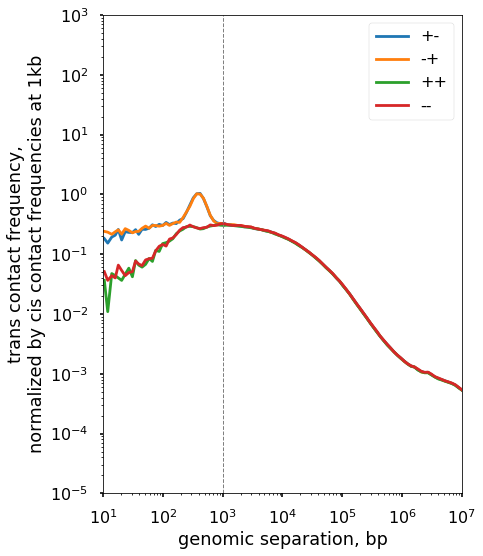

In [27]:
NORMALIZATION_DISTANCE = 1000

sample = 'WT'
for orient in ['+-', '-+', '++', '--']:
    bin_means = np.sqrt(scalings_cis[sample]['chr2L_057']['++'][0][:-1] 
                        * scalings_cis[sample]['chr2L_057']['++'][0][1:])
    
    ref_bin = np.searchsorted(bin_means, NORMALIZATION_DISTANCE)
    
    contact_counts_cis = sum(scalings_cis[sample][chrom][o][1] 
               for chrom in scalings_cis[sample]
               for o in scalings_cis[sample][chrom]
             )
    
    areas_cis = sum(scalings_cis[sample][chrom][o][2] 
                for chrom in scalings_cis[sample]
                for o in scalings_cis[sample][chrom]
              
               )
    contact_freqs_cis = (contact_counts_cis/areas_cis)


    contact_counts_trans = sum(scalings_trans[sample][chrom][orient][1] 
               for chrom in scalings_trans[sample]
             )
    
    areas_trans = sum(scalings_trans[sample][chrom][orient][2] 
                for chrom in scalings_trans[sample]
              
               )
    contact_freqs_trans = (contact_counts_trans/areas_trans)

    
    plt.loglog(
        bin_means, 
        contact_freqs_trans/(contact_freqs_cis[ref_bin]),
        label=orient
    )


plt.axvline(1000, c='gray', ls='--', lw=1)
plt.xlabel('genomic separation, bp')
plt.ylabel('trans contact frequency,\nnormalized by cis contact frequencies at {}kb'.format(NORMALIZATION_DISTANCE//1000))
plt.legend()
plt.ylim(1e-5,1e3)
plt.xlim(1e1,1e7)
plt.gca().set_aspect(1.0)
# plt.plot(
#     [1e3,1e7],
#     [1e1,10**(1-1.5*4)],
#     ls='--',
#     c='gray',
#     lw=0.5)
# for fmt in ['png', 'pdf']:
#     plt.savefig(figfolder+'/slmb_cis_scalings.{}'.format(fmt),
#                 bbox_inches='tight')